# Synthetic data test: Effect of random noise on the solution

In this test, we'll investigate how Euler inversion performs for increasing levels of random noise in the data. We'll compare the results of Euler deconvolution and Euler inversion with and without weights.

In [1]:
from pathlib import Path
import numpy as np
from IPython.display import Image
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Create the model and noise-free data

The model will be a simple dipole so that we can isolate the effect of random noise.

In [3]:
region = [0, 35e3, 0, 25e3]
spacing = 500
height = 800
coordinates = vd.grid_coordinates(region, spacing=spacing, extra_coords=height)
intensity, inclination, declination = 2e12, -30, 15
base_level = 100
true_coordinates = (15e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates,
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(intensity, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly_noiseless = (
    sum(b * f for b, f in zip(magnetic_field, main_field)) + base_level
)

## Make noisy grids with different noise levels

Add pseudo-random Gaussian noise to the data at different levels. Calculate the derivatives using normal methods of finite-differences for the horizontal ones and FFT for the vertical derivative. Warnings from xrft can be safely ignored.

In [4]:
noise_min, noise_max, noise_step = 0, 40, 0.25
noise_levels = np.arange(noise_min, noise_max + noise_step / 2, noise_step)
noisy_data = {}
for noise in noise_levels:
    magnetic_anomaly = magnetic_anomaly_noiseless + np.random.default_rng(42).normal(
        0, noise, size=magnetic_anomaly_noiseless.shape
    )
    # Make a grid and calculate derivatives
    # Can't have the height as a coordinate because of a problem with xrft
    data = vd.make_xarray_grid(
        coordinates[:2],
        (magnetic_anomaly, coordinates[-1]),
        data_names=["field", "height"],
    )
    data["deriv_east"] = hm.derivative_easting(data.field)
    data["deriv_north"] = hm.derivative_northing(data.field)
    pad_width = {
        "easting": data.easting.size // 3,
        "northing": data.northing.size // 3,
    }
    padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
    data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
    # Add back the height
    data = data.assign_coords(height=data.height)
    noisy_data[noise] = data

Plot the generated data so we can see if it looks sensible.

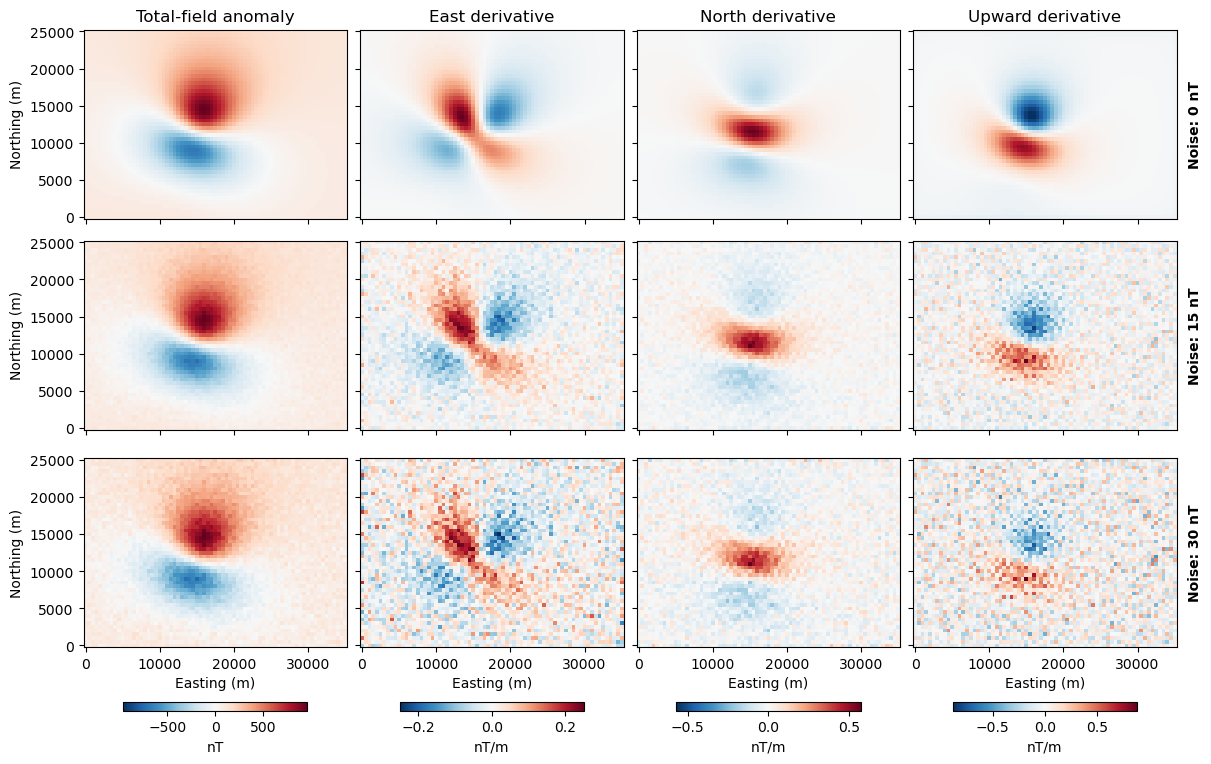

In [5]:
fig, axes = plt.subplots(
    3, 4, figsize=(12, 7.5), layout="constrained", sharex=True, sharey=True
)
units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
titles = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
noise_to_plot = [0, 15, 30]
for i, noise in enumerate(noise_to_plot):
    for field, ax in zip(titles, axes[i, :].ravel()):
        if i == axes.shape[0] - 1:
            kwargs = dict(
                add_colorbar=True,
                cbar_kwargs=dict(
                    orientation="horizontal", aspect=20, shrink=0.7, label=units[field]
                ),
            )
        else:
            kwargs = dict(add_colorbar=False)
        noisy_data[noise][field].plot.pcolormesh(ax=ax, add_labels=False, **kwargs)
        ax.set_aspect("equal")
for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Easting (m)")
for ax, noise in zip(axes[:, -1], noise_to_plot):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(f"Noise: {noise} nT", fontweight="bold", labelpad=8)
for ax, field in zip(axes[0, :], titles):
    ax.set_title(titles[field])
plt.show()

## Run the Euler Inversion and Deconvolution 

Using a single window, run both the deconvolution and inversion on each dataset. Use the correct SI value. The weights used are the default ones defined in `euler.py`.

In [6]:
def euler_inversion_si_estimate(data, weights):
    estimates = []
    for si in [1, 2, 3]:
        estimates.append(
            euler.EulerInversion(structural_index=si).fit_grid(
                data, weights=weights
            )
        )
    rmse = [ei.data_misfit_[-1] for ei in estimates]
    return estimates[np.argmin(rmse)]

In [7]:
estimates_ei = {}
estimates_ei_weights = {}
estimates_ed = {}
weights = euler.DEFAULT_WEIGHTS
for noise in noisy_data:
    data = noisy_data[noise]        
    estimates_ei_weights[noise] = euler_inversion_si_estimate(data, weights)
    estimates_ei[noise] = euler_inversion_si_estimate(data, weights=(1, 1, 1, 1))
    estimates_ed[noise] = euler.EulerDeconvolution(structural_index=3).fit_grid(data)

## Make a figure for the paper

Plot the total-field anomaly and vertical derivative for some noise levels as examples. Plot the error in each coordinate and the base level for all 3 methods tried as a function of the noise level.

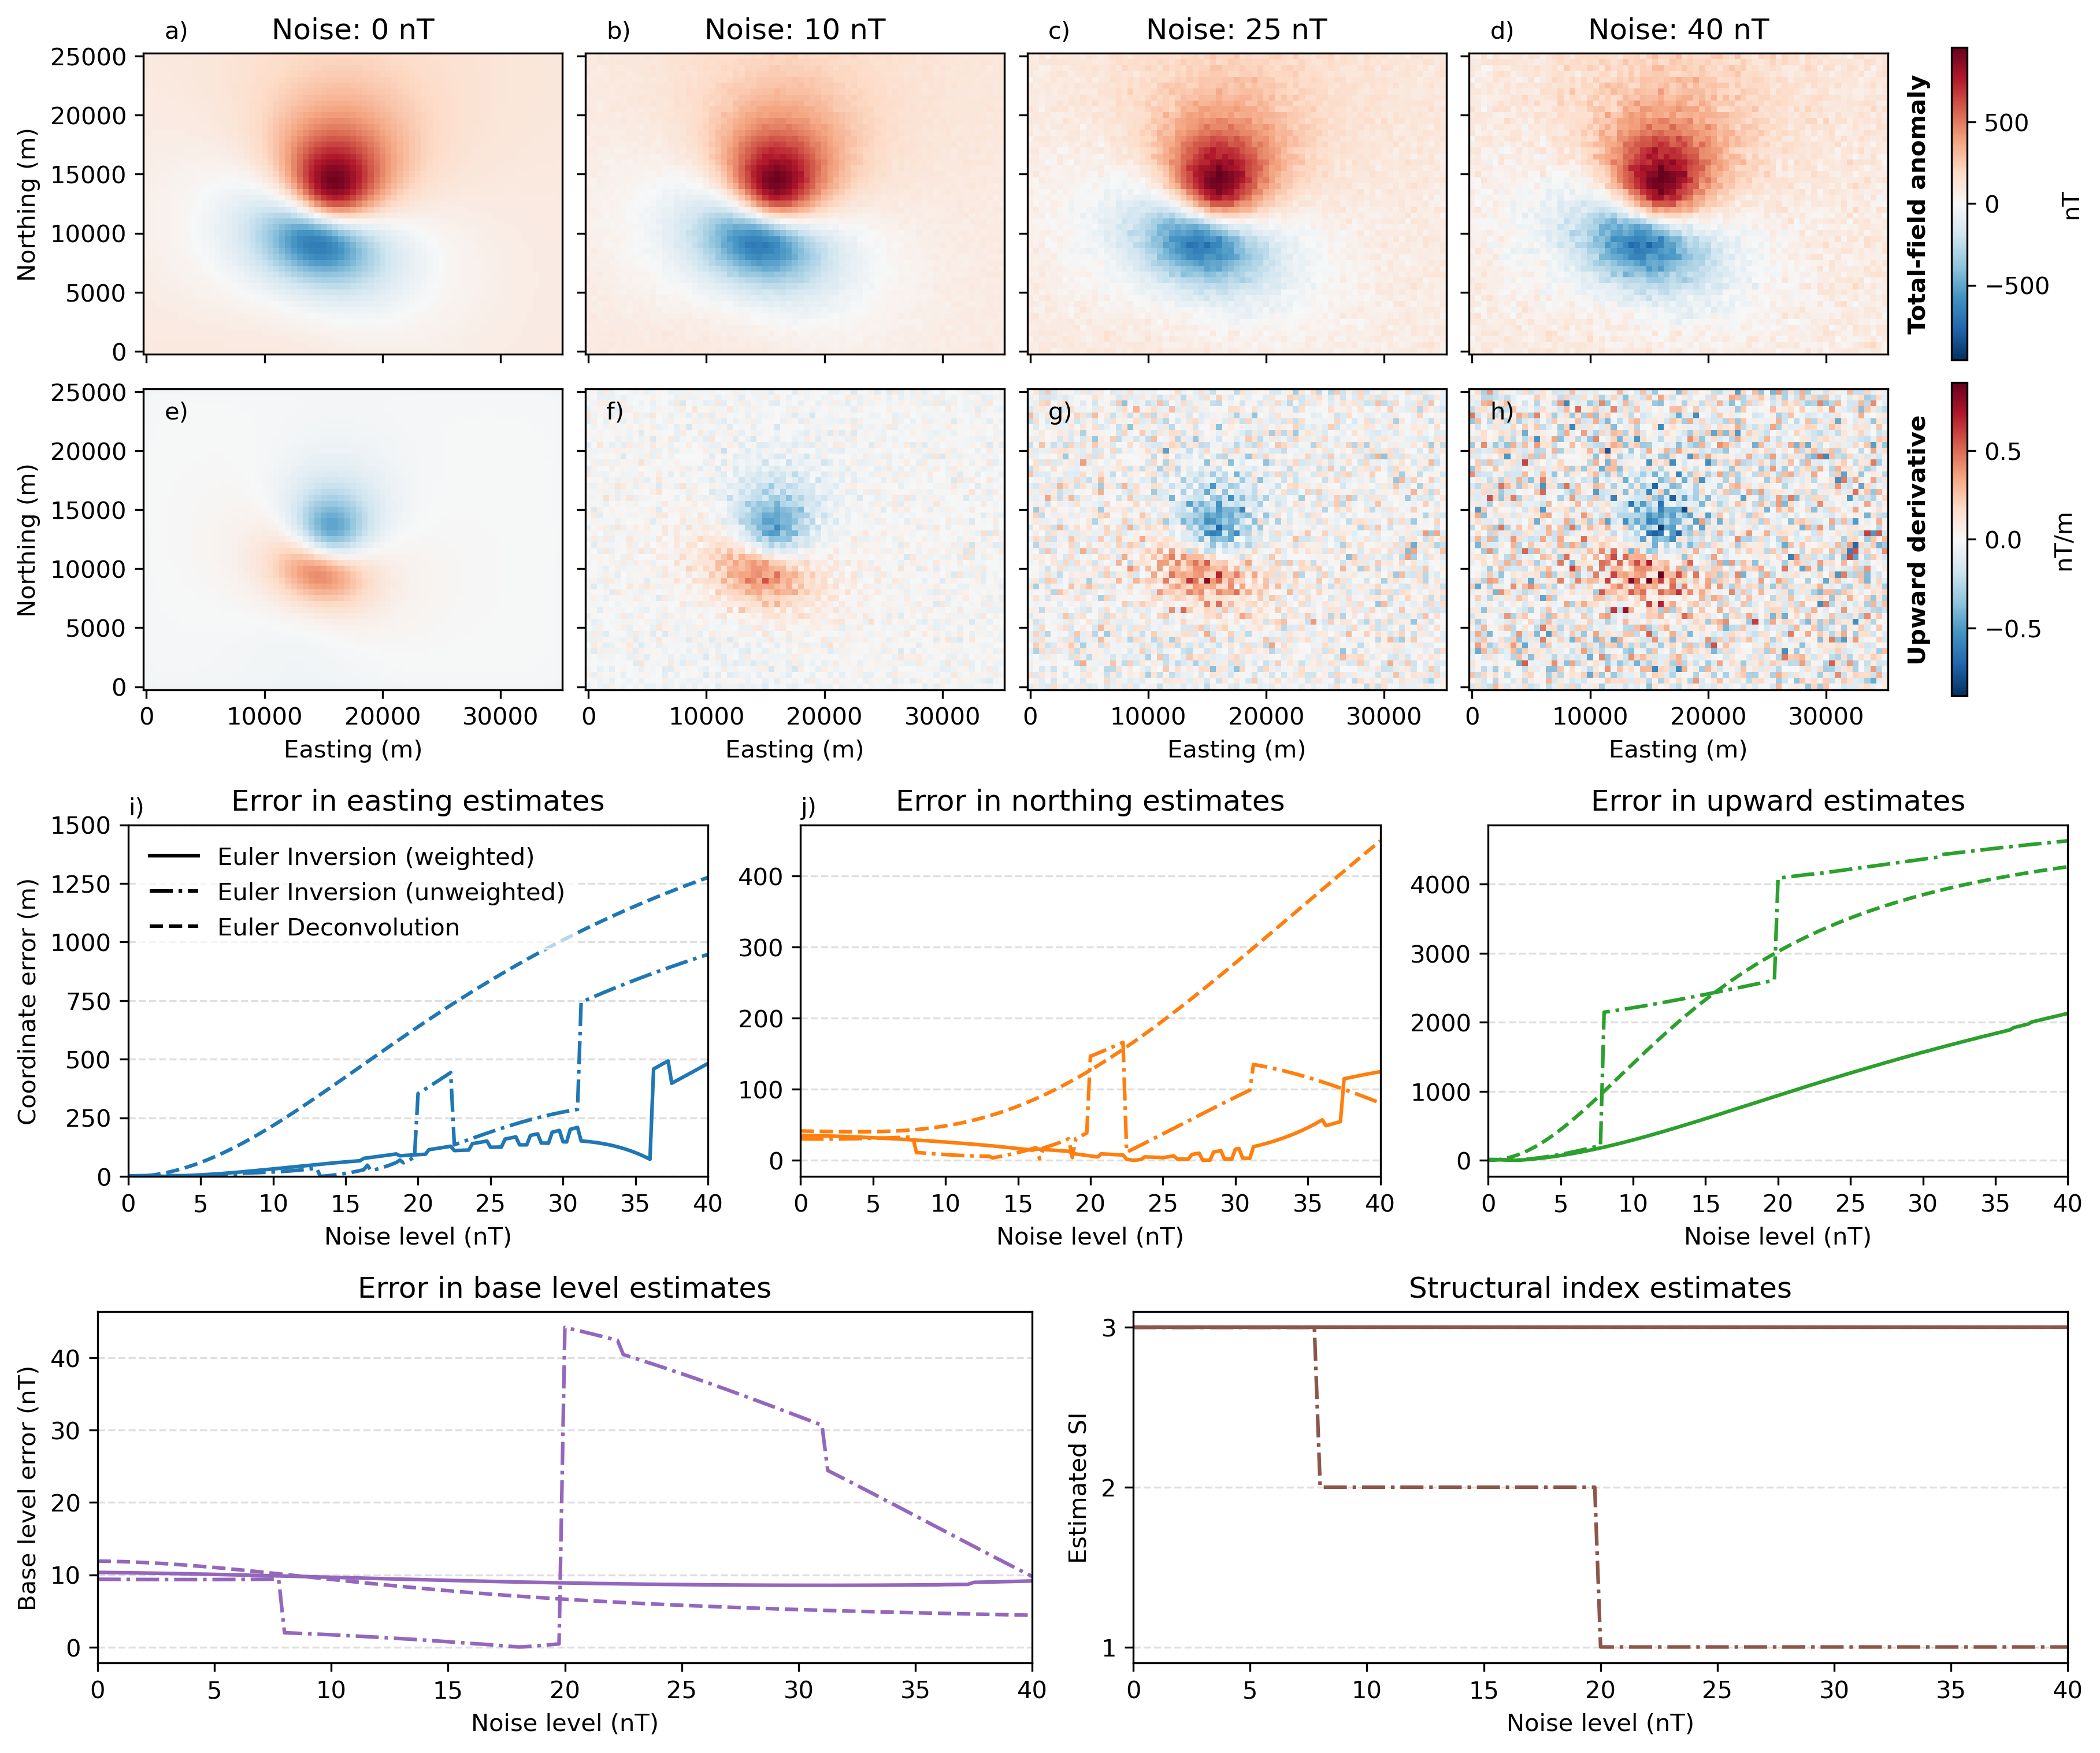

In [8]:
fig = plt.figure(figsize=(12, 10), layout="constrained")

colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])

figures = fig.subfigures(3, 1, height_ratios=[1.6, 1, 1])

axes = figures[0].subplots(2, 4, sharey=True, sharex=True)

units = {"field": "nT", "deriv_east": "nT/m", "deriv_north": "nT/m", "deriv_up": "nT/m"}
titles = {
    "field": "Total-field anomaly",
    "deriv_east": "East derivative",
    "deriv_north": "North derivative",
    "deriv_up": "Upward derivative",
}
noise_to_plot = [0, 10, 25, 40]

for ax in axes.ravel():
    ax.set_aspect("equal")
for ax, label in zip(axes[0, :], "abcd"):
    ax.text(0.05, 1.05, f"{label})", transform=ax.transAxes)
for ax, label in zip(axes[1, :], "efgh"):
    ax.text(0.05, 0.9, f"{label})", transform=ax.transAxes)
scale = vd.maxabs(noisy_data[30].field)
for ax, noise in zip(axes[0, :], noise_to_plot):
    tmp = noisy_data[noise]["field"].plot.pcolormesh(
        ax=ax,
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
        add_labels=False,
        add_colorbar=False,
    )
figures[0].colorbar(tmp, ax=axes[0, -1], label="nT")
scale = vd.maxabs(noisy_data[30].deriv_up)
for ax, noise in zip(axes[1, :], noise_to_plot):
    tmp = noisy_data[noise]["deriv_up"].plot.pcolormesh(
        ax=ax,
        vmin=-scale,
        vmax=scale,
        cmap="RdBu_r",
        add_labels=False,
        add_colorbar=False,
    )
figures[0].colorbar(tmp, ax=axes[1, -1], label="nT/m")

for ax in axes[:, 0]:
    ax.set_ylabel("Northing (m)")
for ax in axes[-1, :]:
    ax.set_xlabel("Easting (m)")
for ax, noise in zip(axes[0, :], noise_to_plot):
    ax.set_title(f"Noise: {noise} nT")
for ax, field in zip(axes[:, -1], ["field", "deriv_up"]):
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(titles[field], fontweight="bold", labelpad=8)

ax1, ax2, ax3 = figures[1].subplots(1, 3)


ax4, ax5 = figures[2].subplots(1, 2)

for ax, label in zip((ax1, ax2, ax3, ax4, ax5), "ij"):
    ax.text(0, 1.03, f"{label})", transform=ax.transAxes)
for estimates, style in zip(
    [estimates_ed, estimates_ei, estimates_ei_weights], ["--", "-.", "-"]
):
    error_position = []
    error_baselevel = []
    estimated_si = []
    for noise in estimates:
        ei = estimates[noise]
        error_position.append(np.abs(np.array(true_coordinates) - ei.location_))
        error_baselevel.append(np.abs(base_level - ei.base_level_))
        estimated_si.append(ei.structural_index)
    error_position = np.array(error_position)
    (east,) = ax1.plot(
        noise_levels,
        error_position[:, 0],
        color=colors[0],
        linestyle=style,
        markersize=5,
    )
    (north,) = ax2.plot(
        noise_levels,
        error_position[:, 1],
        color=colors[1],
        linestyle=style,
        markersize=5,
    )
    (up,) = ax3.plot(
        noise_levels,
        error_position[:, 2],
        color=colors[2],
        linestyle=style,
        markersize=5,
    )
    (base,) = ax4.plot(
        noise_levels,
        error_baselevel,
        color=colors[4],
        linestyle=style,
        markersize=5,
    )
    (si,) = ax5.plot(
        noise_levels,
        estimated_si,
        color=colors[5],
        linestyle=style,
        markersize=5,
    )
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.grid(axis="y", alpha=0.4, linestyle="--")
    ax.set_xlim(min(noise_levels), max(noise_levels))
    ax.set_xlabel("Noise level (nT)")
(inversion_weights,) = ax1.plot([], [], "-k")
(inversion,) = ax1.plot([], [], "-.k")
(deconv,) = ax1.plot([], [], "--k")
ax1.legend(
    [
        inversion_weights,
        inversion,
        deconv,
    ],
    [
        "Euler Inversion (weighted)",
        "Euler Inversion (unweighted)",
        "Euler Deconvolution",
    ],
    framealpha=0.7,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
ax1.set_ylabel("Coordinate error (m)")
ax4.set_ylabel("Base level error (nT)")
ax5.set_ylabel("Estimated SI")
ax1.set_title("Error in easting estimates")
ax2.set_title("Error in northing estimates")
ax3.set_title("Error in upward estimates")
ax4.set_title("Error in base level estimates")
ax5.set_title("Structural index estimates")
ax1.set_ylim(0, 1500)
ax5.set_yticks([1, 2, 3])

# Save the figure and display the saved figure because savefig and
# show can sometimes create slightly different figures
figfile = Path("..") / "paper" / "figures" / "synthetic-noise-levels.png"
fig.savefig(figfile, dpi=300, bbox_inches="tight")
plt.close()
Image(figfile)

## Export a LaTeX file with information for the manuscript

Save things we want to include on the paper so that they can be referenced instead of copied.

In [9]:
output = rf"""
\newcommand{{\SynNoiseWeightsF}}{{{weights[0]}}}
\newcommand{{\SynNoiseWeightsE}}{{{weights[1]}}}
\newcommand{{\SynNoiseWeightsN}}{{{weights[2]}}}
\newcommand{{\SynNoiseWeightsU}}{{{weights[3]}}}
\newcommand{{\SynNoiseTrueEast}}{{\qty{{{true_coordinates[0]:.0f}}}{{\m}}}}
\newcommand{{\SynNoiseTrueNorth}}{{\qty{{{true_coordinates[1]:.0f}}}{{\m}}}}
\newcommand{{\SynNoiseTrueUp}}{{\qty{{{true_coordinates[2]:.0f}}}{{\m}}}}
\newcommand{{\SynNoiseTrueBase}}{{\qty{{{base_level:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynNoiseInt}}{{\qty{{{intensity:.0e}}}{{\ampere\per\meter}}}}
\newcommand{{\SynNoiseDec}}{{\qty{{{declination:.0f}}}{{\degree}}}}
\newcommand{{\SynNoiseInc}}{{\qty{{{inclination:.0f}}}{{\degree}}}}
\newcommand{{\SynNoiseMin}}{{\qty{{{noise_min:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynNoiseMax}}{{\qty{{{noise_max:.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynNoiseStep}}{{\qty{{{noise_step:.1f}}}{{\nano\tesla}}}}
\newcommand{{\SynNoiseHeight}}{{\qty{{{height:.0f}}}{{\m}}}}
\newcommand{{\SynNoiseSpacing}}{{\qty{{{spacing:.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrUEI}}{{\qty{{{np.abs(true_coordinates[2] - estimates_ei[noise_max].location_[2]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrUED}}{{\qty{{{np.abs(true_coordinates[2] - estimates_ed[noise_max].location_[2]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrUEIW}}{{\qty{{{np.abs(true_coordinates[2] - estimates_ei_weights[noise_max].location_[2]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrNEI}}{{\qty{{{np.abs(true_coordinates[1] - estimates_ei[noise_max].location_[1]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrNED}}{{\qty{{{np.abs(true_coordinates[1] - estimates_ed[noise_max].location_[1]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrNEIW}}{{\qty{{{np.abs(true_coordinates[1] - estimates_ei_weights[noise_max].location_[1]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrEEI}}{{\qty{{{np.abs(true_coordinates[0] - estimates_ei[noise_max].location_[0]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrEED}}{{\qty{{{np.abs(true_coordinates[0] - estimates_ed[noise_max].location_[0]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrEEIW}}{{\qty{{{np.abs(true_coordinates[0] - estimates_ei_weights[noise_max].location_[0]):.0f}}}{{\m}}}}
\newcommand{{\SynNoiseErrBEI}}{{\qty{{{np.abs(base_level - estimates_ei[noise_max].base_level_):.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynNoiseErrBED}}{{\qty{{{np.abs(base_level - estimates_ed[noise_max].base_level_):.0f}}}{{\nano\tesla}}}}
\newcommand{{\SynNoiseErrBEIW}}{{\qty{{{np.abs(base_level - estimates_ei_weights[noise_max].base_level_):.0f}}}{{\nano\tesla}}}}
""".strip()
path = Path("..") / "paper" / "variables" / "synthetic-noise-levels.tex"
path.write_text(output)
print(output)

\newcommand{\SynNoiseWeightsF}{1}
\newcommand{\SynNoiseWeightsE}{0.1}
\newcommand{\SynNoiseWeightsN}{0.1}
\newcommand{\SynNoiseWeightsU}{0.025}
\newcommand{\SynNoiseTrueEast}{\qty{15000}{\m}}
\newcommand{\SynNoiseTrueNorth}{\qty{11000}{\m}}
\newcommand{\SynNoiseTrueUp}{\qty{-5000}{\m}}
\newcommand{\SynNoiseTrueBase}{\qty{100}{\nano\tesla}}
\newcommand{\SynNoiseInt}{\qty{2e+12}{\ampere\per\meter}}
\newcommand{\SynNoiseDec}{\qty{15}{\degree}}
\newcommand{\SynNoiseInc}{\qty{-30}{\degree}}
\newcommand{\SynNoiseMin}{\qty{0}{\nano\tesla}}
\newcommand{\SynNoiseMax}{\qty{40}{\nano\tesla}}
\newcommand{\SynNoiseStep}{\qty{0.2}{\nano\tesla}}
\newcommand{\SynNoiseHeight}{\qty{800}{\m}}
\newcommand{\SynNoiseSpacing}{\qty{500}{\m}}
\newcommand{\SynNoiseErrUEI}{\qty{4628}{\m}}
\newcommand{\SynNoiseErrUED}{\qty{4252}{\m}}
\newcommand{\SynNoiseErrUEIW}{\qty{2128}{\m}}
\newcommand{\SynNoiseErrNEI}{\qty{81}{\m}}
\newcommand{\SynNoiseErrNED}{\qty{449}{\m}}
\newcommand{\SynNoiseErrNEIW}{\qty{125}{\m}}
\new